In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance

import xarray as xr
from xarray import Dataset, DataArray

from pykalman import KalmanFilter

sns.set_style('whitegrid')

In [5]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
ds = base_ds.merge(market_brief_ds).dropna(dim='day')
ds

<xarray.Dataset>
Dimensions:            (day: 998, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/22)
    open               (day, asset, timeslot) float64 25.02 24.96 ... 9.941
    close              (day, asset, timeslot) float64 24.96 24.85 ... 9.941
    high               (day, asset, timeslot) float64 25.14 24.96 ... 9.941
    low                (day, asset, timeslot) float64 24.94 24.81 ... 9.88 9.941
    volume             (day, asset, timeslot) float64 6.422e+05 ... 1.851e+05
    money              (day, asset, timeslot) float64 1.61e+07 ... 1.839e+06
    ...                 ...
    mean_volume        (day, asset) float64 4.541e+05 1.769e+05 ... 2.528e+05
    close_0            (day, asset) float64 24.39 16.13 9.031 ... 28.86 9.941
    open_0             (day, asset) float64 25.02 16.33 9.201 ... 28.59 9.674
    high_0             (day, asset) float64 25.14 16.46 9.201 ... 29.05 9.99
    low_0              (day, asset) float64 24.24 15.94 8.921 ... 28.42 9.601
    return_0           (day, asset) float64 -0.02523 -0.0119 ... 0.01992

In [6]:
ds['earnings_ttm'] = ds['close_0'] / ds['pe_ttm']
ds['earnings'] = ds['close_0'] / ds['pe']
ds['book'] = ds['close_0'] / ds['pb']
ds['sales'] = ds['close_0'] / ds['ps']
ds['cashflow'] = ds['close_0'] / ds['pcf']

In [8]:
ds['market_share_history'] = ds['volume'].sum('timeslot') / ds['turnoverRatio']
ds['market_share'] = ds['market_share_history'].sel(day=slice(990, 1000)).median(dim='day')
ds['market_cap'] = ds['market_share'] * ds['close_0'] / 1e8

In [9]:
ds

<xarray.Dataset>
Dimensions:               (day: 998, asset: 54, timeslot: 50)
Coordinates:
  * day                   (day) int32 1 2 3 4 5 6 7 ... 993 994 995 996 997 998
  * asset                 (asset) int32 0 1 2 3 4 5 6 7 ... 47 48 49 50 51 52 53
  * timeslot              (timeslot) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
Data variables: (12/30)
    open                  (day, asset, timeslot) float64 25.02 24.96 ... 9.941
    close                 (day, asset, timeslot) float64 24.96 24.85 ... 9.941
    high                  (day, asset, timeslot) float64 25.14 24.96 ... 9.941
    low                   (day, asset, timeslot) float64 24.94 24.81 ... 9.941
    volume                (day, asset, timeslot) float64 6.422e+05 ... 1.851e+05
    money                 (day, asset, timeslot) float64 1.61e+07 ... 1.839e+06
    ...                    ...
    book                  (day, asset) float64 4.934 3.191 1.878 ... 4.989 4.981
    sales                 (day, asset) float64 6.387 5.292 2.182 ... 7.77 24.41
    cashflow              (day, asset) float64 -0.04213 0.6771 ... 0.07389
    market_share_history  (day, asset) float64 6.171e+06 3.516e+06 ... 9.775e+06
    market_share          (asset) float64 1.026e+07 7.648e+06 ... 9.775e+06
    market_cap            (asset, day) float64 2.503 2.422 ... 0.9527 0.9717

# Let the filter run!

In [32]:
obs_mat_raw = ds[['earnings_ttm', 'book', 'sales', 'cashflow']].sel(asset=0).to_array().to_numpy().T
obs_mat = np.concatenate((obs_mat_raw, np.ones((obs_mat_raw.shape[0], 1))), axis=1)[:, None, :]
y = ds['market_cap'].sel(asset=0).to_numpy()
obs_mat.shape, y.shape

((998, 1, 5), (998,))

In [37]:
feature_n = obs_mat.shape[2]
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(feature_n) # How much random walk wiggles

kf = KalmanFilter(n_dim_obs=1, n_dim_state=feature_n, # y is 1-dimensional, feature is 4-dimensional
                  initial_state_mean=np.zeros((feature_n,)),
                  initial_state_covariance=np.eye(feature_n),
                  observation_matrices=obs_mat,
                  transition_matrices=np.eye(feature_n),
                  transition_covariance=trans_cov,
                  em_vars=[
                      # 'transition_matrices',
                      # 'observation_matrices',
                      'transition_offsets', 
                      'observation_offsets',
                      # 'transition_covariance',
                      'observation_covariance',
                      # 'initial_state_mean',
                      # 'initial_state_covariance',
                  ])

In [38]:
kf.em(y)

In [39]:
state_mean, state_cov = kf.filter(y)

In [42]:
projected_mean = np.einsum('ij,ij->i', state_mean, obs_mat[:, 0, :])

In [48]:
df = pd.DataFrame({'true': ds['market_cap'].sel(asset=0).to_series(), 'projected': projected_mean})

<Axes: xlabel='day'>

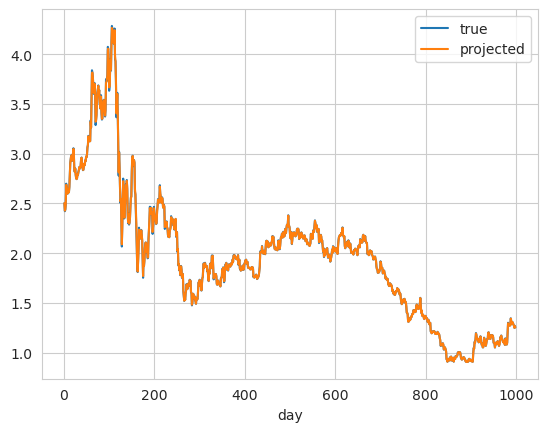

In [49]:
df.plot()

In [123]:
day_range = range(540, 600)

In [149]:
funda_df = ds[['earnings_ttm', 'book', 'sales', 'cashflow']].sel(day=600).to_array().to_numpy().T
from sklearn.preprocessing import KBinsDiscretizer
funda_df_q = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile').fit_transform(funda_df)
print(funda_df_q)
print(funda_df_q.shape)

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
kmeans = KMeans(n_clusters=4, n_init='auto').fit(funda_df_q)
kmeans.labels_

[[3. 4. 2. 3.]
 [3. 3. 3. 1.]
 [2. 1. 1. 2.]
 [3. 3. 4. 4.]
 [0. 0. 0. 2.]
 [1. 0. 0. 2.]
 [1. 0. 3. 1.]
 [4. 3. 1. 1.]
 [1. 0. 0. 3.]
 [1. 0. 1. 2.]
 [2. 3. 1. 4.]
 [3. 2. 1. 1.]
 [1. 1. 2. 0.]
 [3. 1. 1. 3.]
 [0. 2. 0. 3.]
 [4. 3. 3. 0.]
 [0. 2. 2. 1.]
 [0. 2. 0. 0.]
 [4. 4. 4. 0.]
 [0. 1. 0. 1.]
 [2. 0. 1. 3.]
 [3. 3. 4. 4.]
 [3. 2. 1. 3.]
 [1. 1. 0. 2.]
 [2. 3. 1. 0.]
 [3. 2. 2. 4.]
 [0. 1. 0. 4.]
 [1. 1. 2. 0.]
 [4. 4. 4. 4.]
 [4. 4. 3. 1.]
 [4. 4. 4. 4.]
 [0. 3. 3. 4.]
 [0. 0. 0. 2.]
 [4. 3. 2. 3.]
 [2. 0. 3. 3.]
 [3. 4. 4. 4.]
 [4. 4. 2. 4.]
 [4. 4. 3. 0.]
 [2. 0. 0. 2.]
 [0. 0. 1. 1.]
 [1. 0. 1. 2.]
 [1. 1. 2. 1.]
 [2. 3. 4. 0.]
 [2. 2. 4. 2.]
 [0. 4. 0. 0.]
 [2. 3. 4. 1.]
 [4. 4. 4. 0.]
 [4. 4. 3. 3.]
 [1. 1. 2. 3.]
 [0. 2. 3. 2.]
 [2. 2. 3. 4.]
 [1. 1. 2. 3.]
 [3. 2. 3. 1.]
 [3. 1. 4. 0.]]
(54, 4)


array([2, 0, 1, 2, 1, 1, 1, 3, 1, 1, 2, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2,
       2, 1, 0, 2, 1, 1, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 1, 1, 1, 1, 0, 0,
       1, 0, 3, 2, 1, 0, 2, 1, 0, 0], dtype=int32)

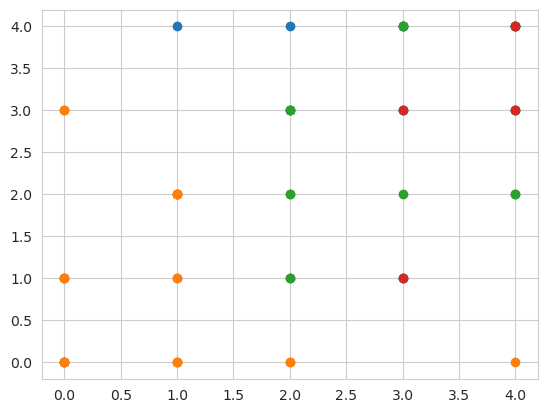

In [151]:
for i in range(8):
    sele = np.where(kmeans.labels_ == i)
    plt.scatter(funda_df_q[sele, 1], funda_df_q[sele, 2])

In [152]:
asset_group, = np.where(kmeans.labels_ == 0)

In [153]:
obs_mat_raw = ds[['earnings_ttm', 'book', 'sales', 'cashflow']
                ].sel(day=day_range, asset=asset_group).to_array('feature').transpose('day', 'asset', 'feature').to_numpy()
obs_mat = np.concatenate((obs_mat_raw, np.ones(obs_mat_raw.shape[:2])[:, :, None]), axis=2)
y = ds['market_cap'].sel(day=day_range, asset=asset_group).transpose('day', 'asset').to_numpy()
obs_mat.shape, y.shape

((60, 9, 5), (60, 9))

In [154]:
feature_n = obs_mat.shape[2]
delta = 1e-2
trans_cov = delta / (1 - delta) * np.eye(feature_n) # How much random walk wiggles

kf = KalmanFilter(n_dim_obs=obs_mat.shape[1], n_dim_state=feature_n, # y is 1-dimensional, feature is 4-dimensional
                  initial_state_mean=np.zeros((feature_n,)),
                  initial_state_covariance=np.eye(feature_n),
                  observation_matrices=obs_mat,
                  transition_matrices=np.eye(feature_n),
                  transition_covariance=trans_cov,
                  em_vars=[
                      # 'transition_matrices',
                      # 'observation_matrices',
                      'transition_offsets', 
                      'observation_offsets',
                      # 'transition_covariance',
                      'observation_covariance',
                      # 'initial_state_mean',
                      # 'initial_state_covariance',
                  ])

In [155]:
kf.em(y)

In [156]:
state_mean, state_cov = kf.filter(y)
state_mean.shape, state_cov.shape

((60, 5), (60, 5, 5))

In [157]:
projected_cap = np.einsum('ij,ikj->ik', state_mean, obs_mat)

<Axes: xlabel='day'>

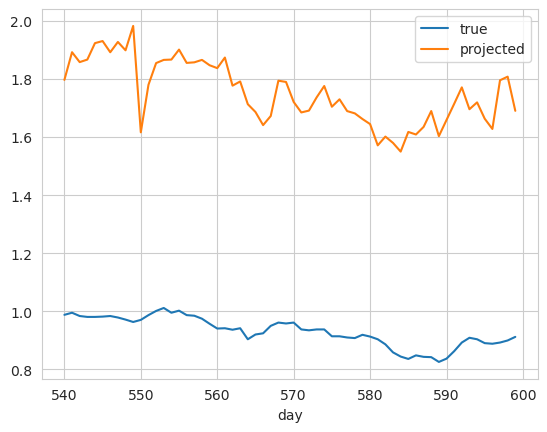

In [164]:
asset_i = 5
pd.DataFrame({'true': ds['market_cap'].sel(day=day_range).sel(asset=asset_group[asset_i]).to_series(), 'projected': projected_cap[:, asset_i]}).plot()

In [180]:
dds = ds.sel(day=600)
ddf = dds[['book', 'market_cap', 'cashflow', 'earnings', 'earnings_ttm', 'sales']].to_dataframe()

(0.0, 20.0)

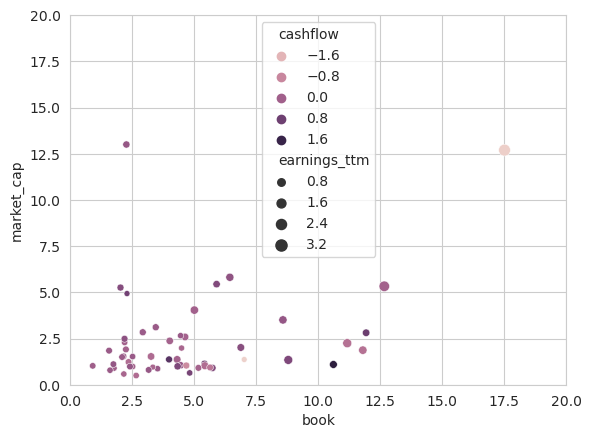

In [183]:
sns.scatterplot(data=ddf.drop(index=28), x='book', y='market_cap', hue='cashflow', size='earnings_ttm')
plt.xlim([0, 20])
plt.ylim([0, 20])

In [ ]:
for asset_i in range(54):
    plt.figure()
    ds.sel(asset=asset_i)[['book', 'market_cap', 'earnings']].to_array().plot.line(x='day')
    plt.figure()
    ds.sel(asset=asset_i)['market_share_history'].plot.line(x='day')

# Can PCA save the day?!

In [214]:
bucket_close = ds.sel(day=range(400, 404)).stack({'bucket': ['day', 'timeslot']})['close']
bucket_return = (bucket_close.diff(dim='bucket') / bucket_close - 1)

In [215]:
bucket_return_long = bucket_return.unstack().fillna(0).stack({'bucket': ['day', 'timeslot']})

In [216]:
bucket_return_long.to_numpy().shape

(54, 200)

In [217]:
from sklearn.decomposition import PCA

pca = PCA().fit(bucket_return_long)

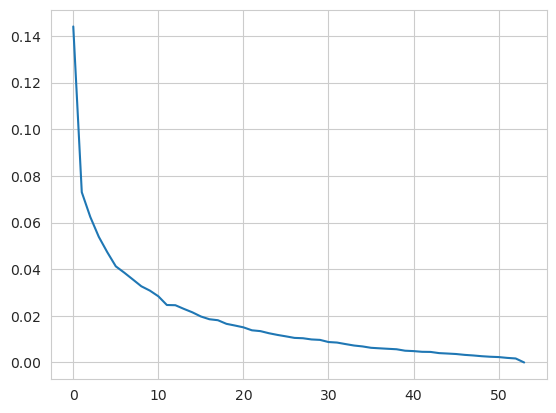

In [218]:
plt.plot(pca.explained_variance_ratio_)

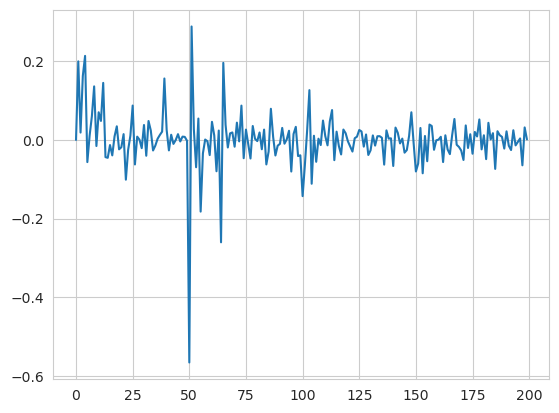

In [220]:
plt.plot(pca.components_[0, :])